In [23]:
import os
import numpy as np
import PIL.Image as img
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from skimage.io import imread, imshow, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose, DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm.notebook import tqdm

im_width = 128
im_height = 128
path_train = "G:/滑坡数据集/语义分割参数和数据和结果/1000/"

def get_data(path, train=True):
    
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):  
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/labels/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X


In [24]:
X, y = get_data(path_train, train=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

Getting and resizing images ... 



Done!


In [3]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.25, 0.75, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)


def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = DepthwiseConv2D(kernel_size=(kernel_size, kernel_size), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(1,1))(x)

    x = DepthwiseConv2D(kernel_size=(kernel_size, kernel_size), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(1,1))(x)

    return x

def get_unet(input_img, n_filters=16, dropout=0.5):
    # 下采样
    c1 = Conv2D(filters=n_filters*1, kernel_size=(3,3), kernel_initializer="he_normal", padding="same")(input_img)
    x = BatchNormalization()(c1)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters*1, kernel_size=(3, 3), kernel_initializer="he_normal",padding="same")(x)
    x = BatchNormalization()(x)
    c1 = Activation("relu")(x)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters*2, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters*4, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters*8, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters*16, kernel_size=3)

    # 上采样
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters*8, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters*4, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters*2, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters*1, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [4]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", my_iou_metric])
model.summary()

callbacks = [
    EarlyStopping(patience=10, verbose=1),  
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('PW_128_landslide.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=16, epochs=20, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
__________________________________________________________________________________________________
Layer (type

Train on 850 samples, validate on 150 samples
Epoch 1/20
850/850 [==============================] - 30s 36ms/step - loss: 0.6264 - acc: 0.6115 - my_iou_metric: 0.5061 - val_loss: 2.2243 - val_acc: 0.5366 - val_my_iou_metric: 0.6760

Epoch 00001: val_loss improved from inf to 2.22434, saving model to PW_128_landslide.h5
Epoch 2/20
850/850 [==============================] - 21s 25ms/step - loss: 0.5749 - acc: 0.6572 - my_iou_metric: 0.6076 - val_loss: 1.2300 - val_acc: 0.5957 - val_my_iou_metric: 0.7087

Epoch 00002: val_loss improved from 2.22434 to 1.23003, saving model to PW_128_landslide.h5
Epoch 3/20
850/850 [==============================] - 21s 25ms/step - loss: 0.5648 - acc: 0.6635 - my_iou_metric: 0.6256 - val_loss: 1.2198 - val_acc: 0.5889 - val_my_iou_metric: 0.7060

Epoch 00003: val_loss improved from 1.23003 to 1.21982, saving model to PW_128_landslide.h5
Epoch 4/20
850/850 [==============================] - 21s 25ms/step - loss: 0.5596 - acc: 0.6685 - my_iou_metric: 0.6445 

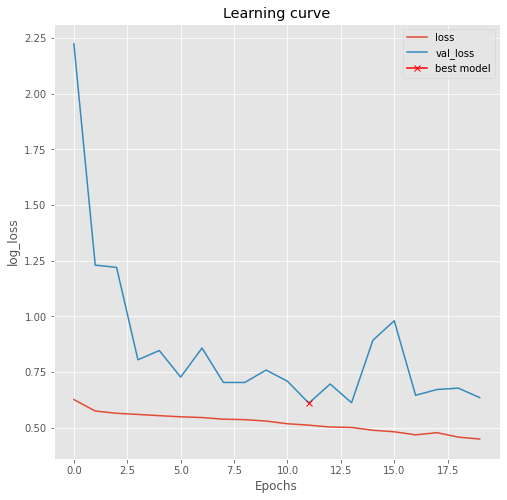

In [5]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [6]:
threshold = 0.5

In [7]:
scores = model.evaluate(X_valid, y_valid, verbose=1)

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

150/150 [==============================] - 1s 6ms/step


In [8]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Landslide')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Landslide Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Landslide Predicted binary');

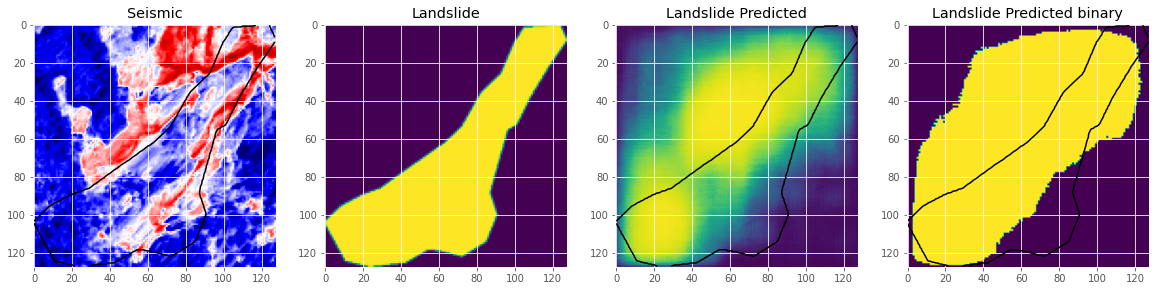

In [17]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t > threshold, ix=16)